# Task 5 — Modeling & Evaluation (Random Forest)
This notebook trains a Random Forest classifier to predict `churn` using `data_for_predictions.csv`.
It includes:
- data loading and cleaning
- baseline model training and evaluation
- hyperparameter tuning via RandomizedSearchCV
- final evaluation metrics (accuracy, precision, recall, f1, ROC-AUC)
- feature importance visualization


# Feature Engineering and Modelling

---

1. Import packages
2. Load data
3. Modelling

---

## 1. Import packages

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt

# Shows plots in jupyter notebook
%matplotlib inline

# Set plot style
sns.set(color_codes=True)

---
## 2. Load data

In [ ]:
df = pd.read_csv('./data_for_predictions.csv')
df.drop(columns=["Unnamed: 0"], inplace=True)
df.head()

,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,...,months_modif_prod,months_renewal,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw
0,24011ae4ebbe3035111d65fa7c15bc57,0.000000,4.739944,0.000000,0.000000,0.0,0.444045,0.114481,0.098142,40.606701,...,2,6,0,0,1,0,0,0,0,1
1,d29c2c54acc38ff3c0614d0a653813dd,3.668479,0.000000,0.000000,2.280920,0.0,1.237292,0.145711,0.000000,44.311378,...,76,4,1,0,0,0,0,1,0,0
2,764c75f661154dac3a6c254cd082ea7d,2.736397,0.000000,0.000000,1.689841,0.0,1.599009,0.165794,0.087899,44.311378,...,68,8,0,0,1,0,0,1,0,0
3,bba03439a292a1e166f80264c16191cb,3.200029,0.000000,0.000000,2.382089,0.0,1.318689,0.146694,0.000000,44.311378,...,69,9,0,0,0,1,0,1,0,0
4,149d57cf92fc41cf94415803a877cb4b,3.646011,0.000000,2.721811,2.650065,0.0,2.122969,0.116900,0.100015,40.606701,...,71,9,1,0,0,0,0,1,0,0


---

## 3. Modelling

We now have a dataset containing features that we have engineered and we are ready to start training a predictive model. Remember, we only need to focus on training a `Random Forest` classifier.

In [ ]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

### Data sampling

The first thing we want to do is split our dataset into training and test samples. The reason why we do this, is so that we can simulate a real life situation by generating predictions for our test sample, without showing the predictive model these data points. This gives us the ability to see how well our model is able to generalise to new data, which is critical.

A typical % to dedicate to testing is between 20-30, for this example we will use a 75-25% split between train and test respectively.

In [ ]:
# Make a copy of our data
train_df = df.copy()

# Separate target variable from independent variables
y = df['churn']
X = df.drop(columns=['id', 'churn'])
print(X.shape)
print(y.shape)

(14606, 61)
(14606,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(10954, 61)
(10954,)
(3652, 61)
(3652,)


In [1]:
# Cell 2 - Imports & settings
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, classification_report, roc_auc_score,
                             roc_curve)
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib
import warnings
warnings.filterwarnings('ignore')
RANDOM_STATE = 42
plt.rcParams['figure.figsize'] = (8,5)


In [2]:
# Cell 3 - Load data
# change path if needed
LOCAL_PATH = r"C:\Users\HP\Desktop\data_for_predictions.csv"
ALT_PATH = "/mnt/data/data_for_predictions.csv"  # fallback (environment)
csv_path = LOCAL_PATH if os.path.exists(LOCAL_PATH) else (ALT_PATH if os.path.exists(ALT_PATH) else None)
if csv_path is None:
    raise FileNotFoundError(f"data_for_predictions.csv not found. Update LOCAL_PATH variable to the correct path.")

print("Loading:", csv_path)
df = pd.read_csv(csv_path)
print("Shape:", df.shape)
display(df.head(3))
print("\nColumns:", df.columns.tolist())
print("\nDtypes:")
display(df.dtypes)


Loading: C:\Users\HP\Desktop\data_for_predictions.csv
Shape: (14606, 64)


,Unnamed: 0,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,...,months_modif_prod,months_renewal,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw
0,0,24011ae4ebbe3035111d65fa7c15bc57,0.000000,4.739944,0.0,0.000000,0.0,0.444045,0.114481,0.098142,...,2,6,0,0,1,0,0,0,0,1
1,1,d29c2c54acc38ff3c0614d0a653813dd,3.668479,0.000000,0.0,2.280920,0.0,1.237292,0.145711,0.000000,...,76,4,1,0,0,0,0,1,0,0
2,2,764c75f661154dac3a6c254cd082ea7d,2.736397,0.000000,0.0,1.689841,0.0,1.599009,0.165794,0.087899,...,68,8,0,0,1,0,0,1,0,0



Columns: ['Unnamed: 0', 'id', 'cons_12m', 'cons_gas_12m', 'cons_last_month', 'forecast_cons_12m', 'forecast_discount_energy', 'forecast_meter_rent_12m', 'forecast_price_energy_off_peak', 'forecast_price_energy_peak', 'forecast_price_pow_off_peak', 'has_gas', 'imp_cons', 'margin_gross_pow_ele', 'margin_net_pow_ele', 'nb_prod_act', 'net_margin', 'pow_max', 'var_year_price_off_peak_var', 'var_year_price_peak_var', 'var_year_price_mid_peak_var', 'var_year_price_off_peak_fix', 'var_year_price_peak_fix', 'var_year_price_mid_peak_fix', 'var_year_price_off_peak', 'var_year_price_peak', 'var_year_price_mid_peak', 'var_6m_price_off_peak_var', 'var_6m_price_peak_var', 'var_6m_price_mid_peak_var', 'var_6m_price_off_peak_fix', 'var_6m_price_peak_fix', 'var_6m_price_mid_peak_fix', 'var_6m_price_off_peak', 'var_6m_price_peak', 'var_6m_price_mid_peak', 'churn', 'offpeak_diff_dec_january_energy', 'offpeak_diff_dec_january_power', 'off_peak_peak_var_mean_diff', 'peak_mid_peak_var_mean_diff', 'off_peak_

Unnamed: 0                                      int64
id                                             object
cons_12m                                      float64
cons_gas_12m                                  float64
cons_last_month                               float64
                                               ...   
channel_lmkebamcaaclubfxadlmueccxoimlema        int64
channel_usilxuppasemubllopkaafesmlibmsdf        int64
origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws      int64
origin_up_ldkssxwpmemidmecebumciepifcamkci      int64
origin_up_lxidpiddsbxsbosboudacockeimpuepw      int64
Length: 64, dtype: object

In [4]:
# Cell 4 - quick checks
# 1) Target presence
if 'churn' not in df.columns:
    raise KeyError("Target column 'churn' not found in dataset.")

print("Churn value counts:")
print(df['churn'].value_counts(dropna=False))
print("\nMissing values per column (top 20):")
display(df.isnull().sum().sort_values(ascending=False).head(20))


Churn value counts:
churn
0    13187
1     1419
Name: count, dtype: int64

Missing values per column (top 20):


Unnamed: 0                                0
id                                        0
var_6m_price_peak                         0
var_6m_price_mid_peak                     0
churn                                     0
offpeak_diff_dec_january_energy           0
offpeak_diff_dec_january_power            0
off_peak_peak_var_mean_diff               0
peak_mid_peak_var_mean_diff               0
off_peak_mid_peak_var_mean_diff           0
off_peak_peak_fix_mean_diff               0
peak_mid_peak_fix_mean_diff               0
off_peak_mid_peak_fix_mean_diff           0
off_peak_peak_var_max_monthly_diff        0
peak_mid_peak_var_max_monthly_diff        0
off_peak_mid_peak_var_max_monthly_diff    0
off_peak_peak_fix_max_monthly_diff        0
peak_mid_peak_fix_max_monthly_diff        0
off_peak_mid_peak_fix_max_monthly_diff    0
tenure                                    0
dtype: int64

In [5]:
# Cell 5 - Convert numeric-like object columns to numeric where appropriate
# Identify object columns that actually hold numeric-like values
obj_cols = df.select_dtypes(include=['object']).columns.tolist()
converted = []
for col in obj_cols:
    # skip clearly categorical fields we want to keep as-is (channel_*, origin_up_*, id)
    if col.lower().startswith('channel_') or col.lower().startswith('origin_up') or col.lower()=='id':
        continue
    # try to convert
    try:
        coerced = pd.to_numeric(df[col].str.replace(',', '').replace('', np.nan), errors='coerce')
        # if a good portion converted (>=60%) then keep conversion
        non_na_ratio = coerced.notna().mean()
        if non_na_ratio >= 0.60:
            df[col] = coerced
            converted.append(col)
    except Exception:
        pass

print("Columns converted from object->numeric (automatically):", converted)
# Show remaining object columns
print("Remaining object columns:", df.select_dtypes(include=['object']).columns.tolist())


Columns converted from object->numeric (automatically): []
Remaining object columns: ['id']


In [6]:
# Cell 6 - drop identifiers and build X, y
drop_cols = []
if 'id' in df.columns:
    drop_cols.append('id')

# drop any obvious high-cardinality hashed text columns if present (optional)
# leave channel_ and origin_up one-hot features as they are
# Example: if a column named 'origin_up' exists as raw hashed (not one-hot), drop it
if 'origin_up' in df.columns:
    drop_cols.append('origin_up')

print("Columns to drop (if present):", drop_cols)
df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')

# Confirm churn is numeric
if df['churn'].dtype == 'O':
    df['churn'] = pd.to_numeric(df['churn'], errors='coerce')

y = df['churn']
X = df.drop(columns=['churn'])
print("X shape:", X.shape, "y shape:", y.shape)


Columns to drop (if present): ['id']
X shape: (14606, 62) y shape: (14606,)


In [7]:
# Cell 7 - train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train churn distribution:")
print(y_train.value_counts(normalize=True))


Train shape: (11684, 62) Test shape: (2922, 62)
Train churn distribution:
churn
0    0.902859
1    0.097141
Name: proportion, dtype: float64


In [9]:
# Cell 8 - Preprocessing: build lists of numeric and categorical features
numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_train.select_dtypes(include=['object','bool']).columns.tolist()

print("Numeric cols count:", len(numeric_cols))
print("Categorical cols count:", len(cat_cols))
# we will use SimpleImputer (median) for numeric, and most_frequent for categorical
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # Changed 'sparse' to 'sparse_output'
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, cat_cols)
], remainder='drop')

Numeric cols count: 62
Categorical cols count: 0


Fitting baseline RandomForest (may take a moment)...
Done fitting baseline model.
Baseline model metrics:
Accuracy: 0.9097
Precision: 0.9167
Recall: 0.0775
F1-score: 0.1429
ROC-AUC: 0.7051

Classification report:

              precision    recall  f1-score   support

           0       0.91      1.00      0.95      2638
           1       0.92      0.08      0.14       284

    accuracy                           0.91      2922
   macro avg       0.91      0.54      0.55      2922
weighted avg       0.91      0.91      0.87      2922



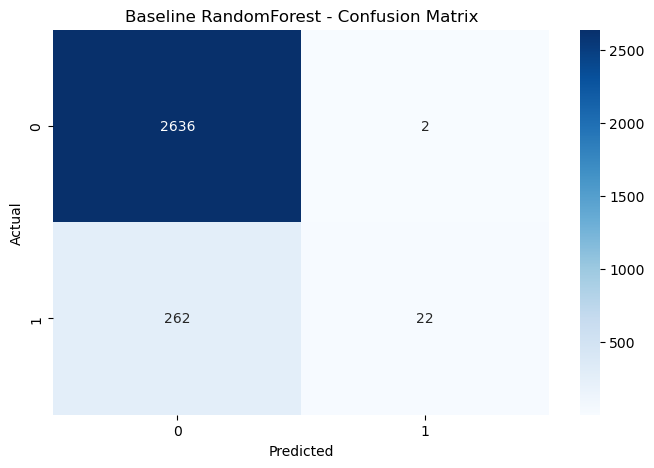

In [10]:
# Cell 9 - Baseline RandomForest (no hyperparameter tuning)
baseline_clf = Pipeline(steps=[
    ('preproc', preprocessor),
    ('clf', RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1, class_weight='balanced'))
])

print("Fitting baseline RandomForest (may take a moment)...")
baseline_clf.fit(X_train, y_train)
print("Done fitting baseline model.")

# Predictions
y_pred = baseline_clf.predict(X_test)
y_proba = baseline_clf.predict_proba(X_test)[:,1] if hasattr(baseline_clf.named_steps['clf'], "predict_proba") else None

# Metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
roc_auc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan

print("Baseline model metrics:")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

print("\nClassification report:\n")
print(classification_report(y_test, y_pred, zero_division=0))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Baseline RandomForest - Confusion Matrix")
plt.show()


## Why these evaluation metrics?
- **Accuracy**: overall correctness (but can be misleading for class imbalance).
- **Precision**: percentage of predicted churns that actually churned — important if false positives are costly.
- **Recall**: percentage of actual churners detected — critical when you want to catch as many churners as possible.
- **F1-score**: harmonic mean of precision & recall, balances both concerns.
- **ROC-AUC**: measures ranking quality of predicted probabilities, useful to evaluate discrimination ability across thresholds.
We use a mix because churn datasets can be imbalanced and different stakeholders care about different error types.


In [18]:
# Cell 11 - Hyperparameter tuning via RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Define RANDOM_STATE if not already defined
RANDOM_STATE = 42  # or whatever value you prefer for reproducibility

# More focused parameter distribution with reasonable ranges
param_dist = {
    'clf__n_estimators': np.arange(100, 1000, 100),  # More granular range
    'clf__max_depth': [None, 10, 20, 30, 40],  # Adjusted depth range
    'clf__min_samples_split': [2, 5, 10],  # Reduced options
    'clf__min_samples_leaf': [1, 2, 4],  # Reduced options
    'clf__max_features': ['sqrt', 'log2', 0.3],  # Focused on common good values
    'clf__bootstrap': [True]  # Bootstrap is usually better for RF
}

# Make sure preprocessor is defined before this cell
# If not defined, you might need to add code to create it

# Create the pipeline
rf_pipeline = Pipeline(steps=[
    ('preproc', preprocessor),
    ('clf', RandomForestClassifier(random_state=RANDOM_STATE, 
                                  class_weight='balanced', 
                                  n_jobs=-1,
                                  oob_score=True))  # Added oob_score for better evaluation
])

# Create the search with stratified k-fold to handle imbalanced data better
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

search = RandomizedSearchCV(
    estimator=rf_pipeline,
    param_distributions=param_dist,
    n_iter=40,  # Increased iterations for better exploration
    scoring='roc_auc',  # You could also use 'f1' or 'balanced_accuracy' for imbalanced data
    cv=cv,  # Using stratified k-fold
    verbose=2,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    return_train_score=True  # This helps detect overfitting
)

# Add timing to see how long the search takes
import time
start_time = time.time()

print("Starting RandomizedSearchCV (this may take several minutes)...")
search.fit(X_train, y_train)

# Print execution time
print(f"RandomizedSearchCV completed in {(time.time() - start_time)/60:.2f} minutes")

# Print results
print("Best params:", search.best_params_)
print("Best CV ROC-AUC:", search.best_score_)

# Store the best model
best_model = search.best_estimator_

# Optional: Plot the learning curves to check for overfitting
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

def plot_learning_curve(estimator, X, y, cv=5, n_jobs=-1):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, 
        train_sizes=np.linspace(0.1, 1.0, 10), scoring='roc_auc')
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, color='blue', marker='o', 
             markersize=5, label='Training ROC-AUC')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, 
                     alpha=0.15, color='blue')
    
    plt.plot(train_sizes, test_mean, color='green', marker='s', 
             markersize=5, label='Validation ROC-AUC')
    plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, 
                     alpha=0.15, color='green')
    
    plt.title('Learning Curve for Best Model')
    plt.xlabel('Training Examples')
    plt.ylabel('ROC-AUC Score')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

# Uncomment to plot learning curve (may take additional time)
# plot_learning_curve(best_model, X_train, y_train)

Starting RandomizedSearchCV (this may take several minutes)...
Fitting 5 folds for each of 40 candidates, totalling 200 fits
RandomizedSearchCV completed in 12.18 minutes
Best params: {'clf__n_estimators': 900, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 4, 'clf__max_features': 0.3, 'clf__max_depth': None, 'clf__bootstrap': True}
Best CV ROC-AUC: 0.6996834047233864


In [21]:
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
import numpy as np
import time

RANDOM_STATE = 42

# Parameter distributions for LightGBM
param_dist = {
    'clf__num_leaves': np.arange(20, 150, 10),        # Controls tree complexity
    'clf__max_depth': [None, -1, 10, 20, 30],         # -1 means no limit
    'clf__learning_rate': np.logspace(-3, 0, 20),     # 0.001 to 1.0
    'clf__n_estimators': np.arange(100, 1000, 100),   # Number of boosting rounds
    'clf__min_child_samples': [5, 10, 20, 30, 50],    # Minimum samples per leaf
    'clf__subsample': [0.6, 0.8, 1.0],                # Row sampling
    'clf__colsample_bytree': [0.6, 0.8, 1.0],         # Feature sampling
    'clf__reg_alpha': [0, 0.1, 0.5, 1.0],             # L1 regularization
    'clf__reg_lambda': [0, 0.1, 0.5, 1.0]             # L2 regularization
}

# Pipeline with preprocessing + LightGBM
lgbm_pipeline = Pipeline(steps=[
    ('preproc', preprocessor),
    ('clf', LGBMClassifier(random_state=RANDOM_STATE, 
                           class_weight='balanced',
                           n_jobs=-1))
])

# Stratified CV for imbalanced data
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Randomized search
search = RandomizedSearchCV(
    estimator=lgbm_pipeline,
    param_distributions=param_dist,
    n_iter=50,                # More iterations for exploration
    scoring='roc_auc',        # ROC-AUC for imbalanced classification
    cv=cv,
    verbose=2,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    return_train_score=True
)

# Timing
start_time = time.time()
print("Starting LightGBM RandomizedSearchCV...")
search.fit(X_train, y_train)
print(f"Completed in {(time.time() - start_time)/60:.2f} minutes")

# Results
print("Best params:", search.best_params_)
print("Best CV ROC-AUC:", search.best_score_)

best_model = search.best_estimator_


Starting LightGBM RandomizedSearchCV...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Info] Number of positive: 1135, number of negative: 10549
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005574 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9818
[LightGBM] [Info] Number of data points in the train set: 11684, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

Tuned model metrics:
Accuracy: 0.9090
Precision: 0.6800
Recall: 0.1197
F1-score: 0.2036
ROC-AUC: 0.7059

Classification report:

              precision    recall  f1-score   support

           0       0.91      0.99      0.95      2638
           1       0.68      0.12      0.20       284

    accuracy                           0.91      2922
   macro avg       0.80      0.56      0.58      2922
weighted avg       0.89      0.91      0.88      2922



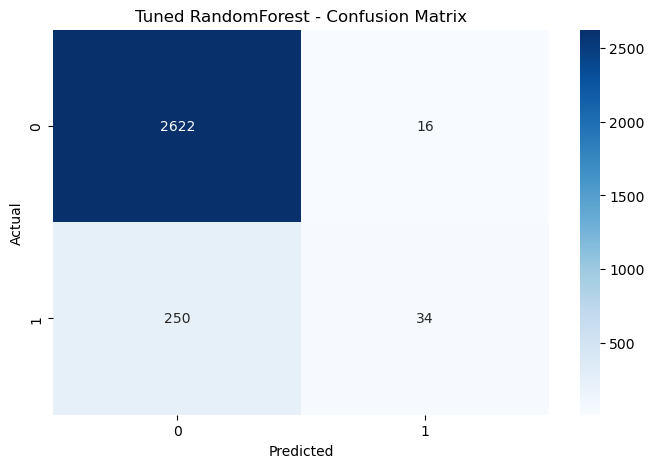

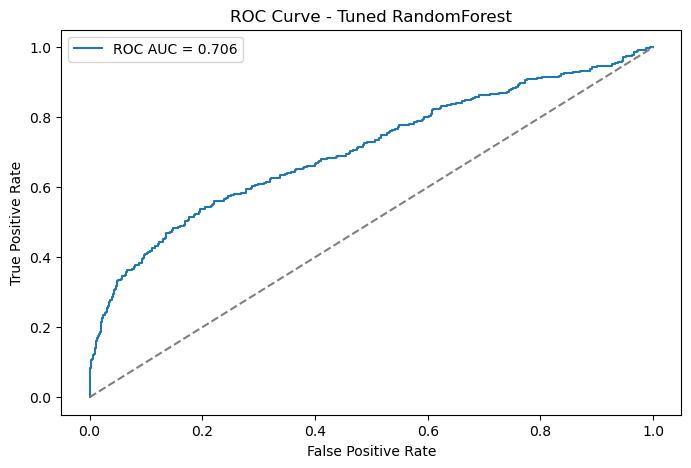

In [14]:
# Cell 12 - evaluate best estimator
best_model = search.best_estimator_
y_pred_tuned = best_model.predict(X_test)
y_proba_tuned = best_model.predict_proba(X_test)[:,1]

acc_t = accuracy_score(y_test, y_pred_tuned)
prec_t = precision_score(y_test, y_pred_tuned, zero_division=0)
rec_t = recall_score(y_test, y_pred_tuned, zero_division=0)
f1_t = f1_score(y_test, y_pred_tuned, zero_division=0)
roc_auc_t = roc_auc_score(y_test, y_proba_tuned)

print("Tuned model metrics:")
print(f"Accuracy: {acc_t:.4f}")
print(f"Precision: {prec_t:.4f}")
print(f"Recall: {rec_t:.4f}")
print(f"F1-score: {f1_t:.4f}")
print(f"ROC-AUC: {roc_auc_t:.4f}\n")

print("Classification report:\n")
print(classification_report(y_test, y_pred_tuned, zero_division=0))

# Confusion matrix
cm2 = confusion_matrix(y_test, y_pred_tuned)
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Tuned RandomForest - Confusion Matrix")
plt.show()

# ROC curve
fpr, tpr, th = roc_curve(y_test, y_proba_tuned)
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc_t:.3f}")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Tuned RandomForest")
plt.legend()
plt.show()


Error getting feature names: This OneHotEncoder instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.


,feature,importance
0,cons_12m,0.060078
1,Unnamed: 0,0.059491
2,margin_net_pow_ele,0.057935
3,forecast_meter_rent_12m,0.057201
4,margin_gross_pow_ele,0.050248
5,net_margin,0.043981
6,forecast_cons_12m,0.041482
7,cons_last_month,0.039829
8,months_activ,0.036222
9,pow_max,0.034650


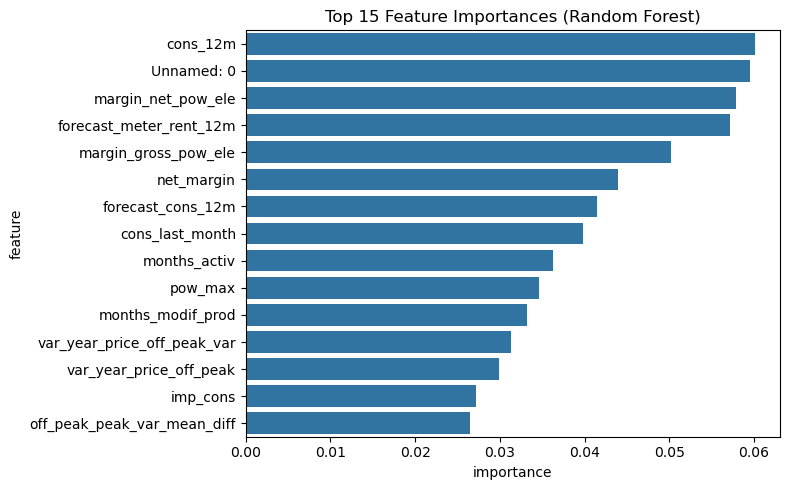

In [17]:
# We need feature names after preprocessing: get from preprocessor + onehot
# Build a function to extract feature names
def get_feature_names_from_column_transformer(col_transformer):
    # Check if the transformer is fitted
    if not hasattr(col_transformer, 'transformers_'):
        raise ValueError("Column transformer is not fitted yet")
    
    # adapted to our simple structure: ('num', numeric_transformer, numeric_cols), ('cat', categorical_transformer, cat_cols)
    feature_names = []
    for name, trans, cols in col_transformer.transformers_:
        # Skip 'drop' or 'passthrough' transformers
        if name == 'drop' or trans == 'drop' or trans == 'passthrough':
            continue
            
        if name == 'num':
            feature_names.extend(cols)
        elif name == 'cat':
            # Make sure the transformer is fitted
            if not hasattr(trans, 'named_steps'):
                continue
                
            # Check if OneHotEncoder exists in the pipeline
            if 'onehot' not in trans.named_steps:
                feature_names.extend(cols)
                continue
                
            ohe = trans.named_steps['onehot']
            
            # Check if the encoder is fitted
            if not hasattr(ohe, 'categories_') and not hasattr(ohe, 'get_feature_names_out'):
                # If not fitted, just use column names
                feature_names.extend([f"{col}_unknown" for col in cols])
                continue
                
            # Try to get feature names using different methods based on scikit-learn version
            try:
                if hasattr(ohe, 'get_feature_names_out'):
                    # For newer scikit-learn versions
                    cat_features = ohe.get_feature_names_out(cols)
                    feature_names.extend(cat_features)
                elif hasattr(ohe, 'categories_'):
                    # For older versions
                    categories = ohe.categories_
                    new_cols = []
                    for orig_col, cat_list in zip(cols, categories):
                        new_cols.extend([f"{orig_col}__{str(c)}" for c in cat_list])
                    feature_names.extend(new_cols)
                else:
                    # Fallback
                    feature_names.extend([f"{col}_unknown" for col in cols])
            except Exception as e:
                # If any error occurs, use a fallback
                print(f"Error getting feature names: {e}")
                feature_names.extend([f"{col}_unknown" for col in cols])
    
    return feature_names

# Make sure the model is fitted before extracting feature names
if hasattr(best_model, 'named_steps') and 'preproc' in best_model.named_steps:
    # extract feature names
    ft_names = get_feature_names_from_column_transformer(best_model.named_steps['preproc'])
    # get importances
    importances = best_model.named_steps['clf'].feature_importances_

    # create df & show top 20
    feat_imp = pd.DataFrame({'feature': ft_names, 'importance': importances})
    feat_imp = feat_imp.sort_values('importance', ascending=False).reset_index(drop=True)
    display(feat_imp.head(20))

    # Plot top 15
    sns.barplot(x='importance', y='feature', data=feat_imp.head(15))
    plt.title("Top 15 Feature Importances (Random Forest)")
    plt.tight_layout()
    plt.show()
else:
    print("Model is not fitted or doesn't have the expected structure")

## Final remarks and interpretation

- We used Random Forest because it handles non-linear relationships, doesn't require feature scaling, and is robust to a mixture of feature types.
- We reported accuracy, precision, recall, F1, confusion matrix and ROC-AUC. Because churn is usually imbalanced and business stakeholders may care about identifying actual churners (recall) while also avoiding too many false positives (precision), reporting multiple metrics is critical.
- Evaluate the tuned model's recall and precision: if recall is high but precision low, you may want business actions that tolerate outreach to some false positives; if precision is high but recall low, you may be missing many churners.
- Next steps: consider calibration of probabilities, cost-sensitive learning, or using uplift modeling if you have treatment data (retention offers).


In [22]:
# Cell 14 - Save model and a short summary
MODEL_OUT = "rf_tuned_model_task5.joblib"
joblib.dump(best_model, MODEL_OUT)
print("Saved tuned model to:", MODEL_OUT)

# Save a summary of results and top features
summary = {
    'accuracy_baseline': float(acc),
    'precision_baseline': float(prec),
    'recall_baseline': float(rec),
    'f1_baseline': float(f1),
    'roc_auc_baseline': float(roc_auc),
    'accuracy_tuned': float(acc_t),
    'precision_tuned': float(prec_t),
    'recall_tuned': float(rec_t),
    'f1_tuned': float(f1_t),
    'roc_auc_tuned': float(roc_auc_t)
}
pd.Series(summary).to_csv("rf_model_metrics_summary.csv")
feat_imp.head(50).to_csv("rf_feature_importances.csv", index=False)
print("Saved metrics summary and feature importances CSVs.")


Saved tuned model to: rf_tuned_model_task5.joblib
Saved metrics summary and feature importances CSVs.
